# Chapter 14 Deep Computer Vision Using Convolutional Neural Networks

Perception is not trivial at all, and to understand it we must look at how the sensory modules in our brains work.     
**Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex.** In the last few years, CNNs have managed to achieve superhuman performance on some complex visual tasks.     

In this chapter we will present **where CNNs came from**, **what their building blocks look like**, and **how to implement** them. Then we will discuss **some of the best CNN architectures**, and discuss **other visual tasks.**

# The Architecture of the Visual Cortex   
**Crucial insights on the structure of the visual cortex:**    
1.the visual cortex have a small local receptive field, meaning they react only to visual stimuli located in a limited region of the visual field     
2.higher-level neurons are based on the outputs of neighboring
lower-level neurons   
These studies of the visual cortex inspired the neocognitron, introduced in 1980, which gradually evolved into what we now call CNN.

![title](img/14_1.png)

**Why not simply use a regular deep neural network with fully connected layers for image recognition tasks?**   
It breaks down for larger images because of the huge number of parameters it requires.

# Convolutional Layer: the first common building block of CNNs   
**Composition:** Neurons in the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields. In turn, each neuron in the second layer is connected only to neurons located within a small rectangle in the first layer.

![title](img/14_2.png)

**Connection between layers:**    
**1.zero padding:** add zeros around the inputs in order for a layer to have the same height and width as the previous layer   
**2.stride:** connect a large input layer to a much smaller layer by spacing out the receptive fields

![title](img/14_3.png)

![title](img/14_4.png)

**Filters:**   
A neuron’s weights can be represented as a small image the size of the receptive field, called filters (or convolution kernels).

![title](img/14_5.png)

A layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most. Of course you do not have to define the filters manually: instead, during training the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns.   
## Stacking Multiple Feature Maps:    
In reality a convolutional layer has **multiple filters**, and it outputs one feature map per filter.   
**Note:** All neurons within a given feature map share the same parameters. However, neurons in different feature maps use different parameters. A neuron’s receptive field extends across all the previous layers’ feature maps.    
**Goal:** Simultaneously apply multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.   
**Input layers**: 3 color channel - red, green, and blue (RGB).

![title](img/14_6.png)

**How to compute the output of a given neuron in a convolutional layer:**   
<center> $z_{i,j,k}=b_k + \sum_{u = 0}^{f_h-1} \sum_{v = 0}^{f_w-1} \sum_{k^{'} = 0}^{f_n^{'}-1} x_{i^{'},j^{'},k^{'}}·w_{u^{'},v^{'},k^{'},k}$ with $i^{'}=i×s_h+u$，$j^{'}=j×s_w+v$ <center>     

All it does is calculate the weighted sum of all the inputs, plus the bias term.

# TensorFlow Implementation   
In TensorFlow, each input image is typically represented as a 3D tensor of shape $[height, width, channels]$. A mini-batch is represented as a 4D tensor of shape $[mini-batch size, height, width, channels]$. The weights of a convolutional layer are represented as a 4D tensor of shape $[f_h, f_{w^{'}}, f_{n^{′}}, f_n]$. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape $[f_n]$.   
Let’s look at a simple example.

In [1]:
# Python ≥3.5、Scikit-Learn ≥0.20、TensorFlow ≥2.0 is required
import numpy as np
import os
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

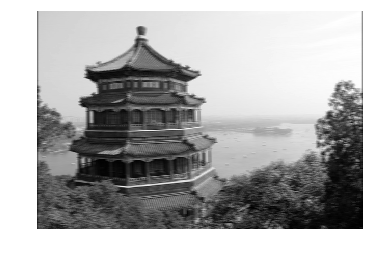

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

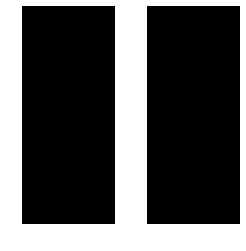

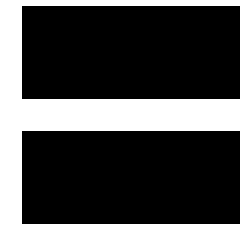

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


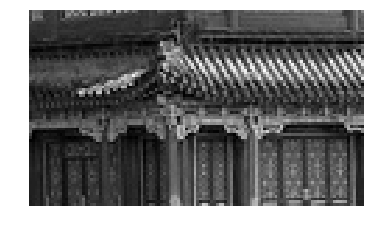

Saving figure china_vertical


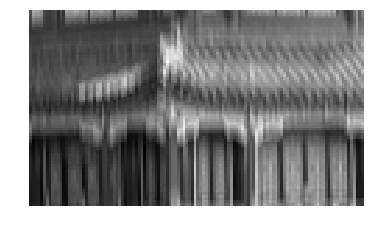

Saving figure china_horizontal


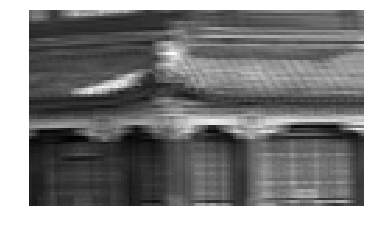

In [6]:
plot_image(crop(images[0, :, :, 0]))
print("Saving figure china_original")
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    print("Saving figure", filename)
    plt.show()

**In a real CNN you would normally define filters as trainable variables:**   
`conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")`

## VALID vs SAME padding
![title](img/14_7.png)

## Memory Requirements   
A **problem** with CNNs is that the convolutional layers require a huge amount of RAM. This is especially true during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.   
Alternatively, you can try **reducing dimensionality** using a stride, or **removing a few layers**. Or you can **try using 16-bit floats** instead of 32-bit floats. Or you could **distribute the CNN** across multiple devices.

# Pooling Layer: the second common building block of CNNs   
**Goal:** to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting)   
**Composition:** Each neuron is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type. However, **a pooling neuron has no weights**; all it does is aggregate the inputs using an aggregation function such as the max or mean.   
![title](img/14_8.png)   
A pooling layer typically works on every input channel independently,
so the output depth is the same as the input depth.

Max pooling layer also introduces some level of **invariance to small translations**.   
![title](img/14_9.png)   
**Features:**   
Such invariance can be **useful** in cases where the prediction should not depend on these details.   
But max pooling has some **downsides:** obviously very destructive; invariance is not desirable in some applications, for example for semantic segmentation.

# TensorFlow Implementation  
Define a max pooling layer: `max_pool = keras.layers.MaxPool2D(pool_size=2)`   
Define a average pooling layer: `max_pool = keras.layers.AvgPool2D(pool_size=2)`   
People **mostly use max pooling layers** now, as they generally perform better because max pooling preserves only the strongest feature, getting rid of all the meaningless ones.   
## Max pooling 

In [14]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [15]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


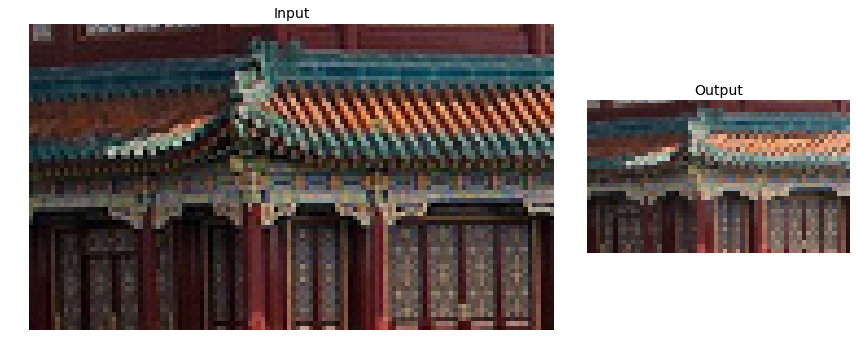

In [16]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
print("Saving figure china_max_pooling")
plt.show()

## Depth-wise pooling
Note that max pooling and average pooling can be **performed along the depth dimension** rather than the spatial dimensions, which allow the CNN to **learn to be invariant to various features.**   
**Define:** `output = tf.nn.max_pool(images,ksize=(1, 1, 1, 3),strides=(1, 1, 1, 3),padding="VALID")` or you can simply wrap it in a Lambda layer.
![title](img/14_10.png) 

In [17]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [18]:
depth_pool = DepthMaxPool(3)
depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a Lambda layer:

In [19]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

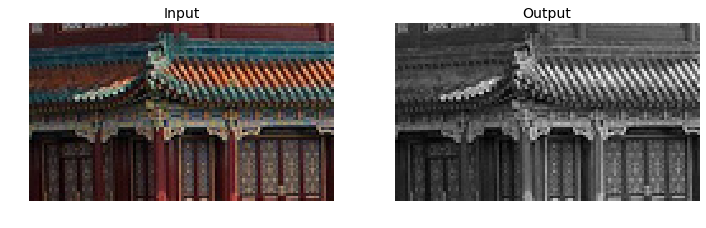

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

In [21]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [22]:
output_avg = avg_pool(cropped_images)

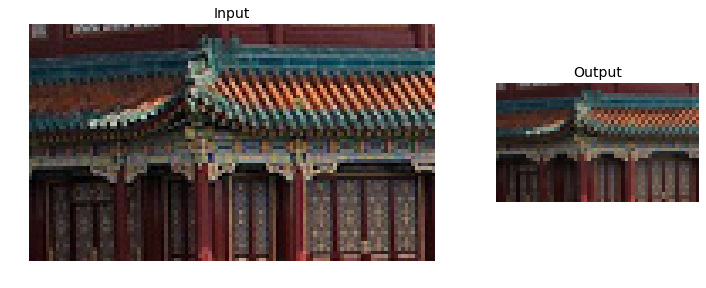

In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling
It works very differently: **all it does is compute the mean of each entire feature map**. This means that it just outputs a single number per feature map and per instance.    
Although this is of course extremely **destructive** (most of the information in the feature map is lost), it can be **useful as the output layer** .         
**Define:** `global_avg_pool = keras.layers.GlobalAvgPool2D()` or `global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))`

In [24]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=151, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

In [25]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=155, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

# CNN Architectures   
Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. At the top of the stack, a regular feedforward neural network is added.   
![title](img/14_11.png)   
**Recommendation:**     
For **the first convolutional layer**: it can typically have a **large kernel** (e.g., 5 × 5), usually with stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information.   
For **the other convolutional layers**: a **small kernel** for less parameters and require less computations.   
# Tackling Fashion MNIST With a CNN

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [27]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 51s 923us/sample - loss: 0.7183 - accuracy: 0.7529 - val_loss: 0.4029 - val_accuracy: 0.8510
Epoch 2/10
55000/55000 [==============================] - 47s 863us/sample - loss: 0.4185 - accuracy: 0.8592 - val_loss: 0.3285 - val_accuracy: 0.8854
Epoch 3/10
55000/55000 [==============================] - 46s 836us/sample - loss: 0.3691 - accuracy: 0.8765 - val_loss: 0.2905 - val_accuracy: 0.8936
Epoch 4/10
55000/55000 [==============================] - 46s 832us/sample - loss: 0.3324 - accuracy: 0.8879 - val_loss: 0.2794 - val_accuracy: 0.8970
Epoch 5/10
55000/55000 [==============================] - 48s 880us/sample - loss: 0.3100 - accuracy: 0.8960 - val_loss: 0.2872 - val_accuracy: 0.8942
Epoch 6/10
55000/55000 [==============================] - 51s 921us/sample - loss: 0.2930 - accuracy: 0.9008 - val_loss: 0.2863 - val_accuracy: 0.8980
Epoch 7/10
55000/55000 [=====================

# Some Other CNN Architectures    
Over the years, variants of this fundamental architecture have been developed. We will look at the classical **LeNet-5 architecture (1998), AlexNet (2012), GoogLeNet (2014), and ResNet
(2015) and so on.**   
# LeNet-5   
It is the most widely known CNN architecture, and widely used for handwritten digit recognition (MNIST).   
![title](img/T14_1.png)   
**Note:**    
**normalized** before being fed to the network;     
the more **complex average pooling layers**(each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient and adds a learnable bias term, then finally applies the activation function);    
**C3 maps** are connected to neurons in only three or four S2
maps;    
**output layer** outputs the square of the Euclidian distance between its input vector and its weight vector.   
# AlexNet   
It was **the first to stack convolutional layers directly** on top of each other, instead of stacking a pooling layer on top of each convolutional layer.   
![title](img/T14_2.png) 
**two used regularization techniques**:    
First they applied **dropout** with a 50% dropout rate during the train of F8 and F9.   
Second, they performed **data augmentation** by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.   
## Data Augmentation   
Slightly **shift, rotate, and resize** every picture and add the resulting pictures to the training set.   
This forces the model to be **more tolerant to variations in the position, orientation, and size of the objects in the pictures.**  
![title](img/14_12.png)   
## Local Response Normalization   
**Definition:** The most strongly activated neurons **inhibit other neurons** located at the same position in neighboring feature maps.   
**Meaning:** encourages different feature maps to **specialize**, pushing them apart and forcing them to **explore a wider range of features.**   
**Implement:** `tf.nn.local_response_normalization()`   
AlexNet uses a competitive normalization step immediately after the ReLU step of layers C1 and C3.  
# GoogLeNet    
Sub-networks called **inception modules** allow GoogLeNet to **use parameters much more efficiently** than previous architectures.   
![title](img/14_13.png)   
**why inception modules have convolutional layers with 1 × 1 kernels:**   
they can capture patterns along the **depth dimension**;   
output fewer feature maps than their inputs, meaning they **reduce dimensionality**;    
able to output feature maps that capture complex patterns at **various scales.**   
![title](img/14_14.png)    
**Features:** The tall stack of nine inception modules, interleaved with a couple max pooling layers to reduce dimensionality and speed up the net.   
# ResNet   
It uses an **extremely deep CNN** composed of 152 layers.
**The key to being able to train:** use skip connections / shortcut connections   
**skip connections:** the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack, 
then the network will be forced to model $f(x) = h(x) – x$ rather than $h(x)$, which can prevent **gradient vanishing problem.** This is called **residual learning.**   
![title](img/14_15.png)   
![title](img/14_16.png)   
**ResNet architecture:** It starts and ends exactly like GoogLeNet (except without a dropout layer), and in between is just **a very deep stack of simple residual units**, e.g. ResNet-34, ResNet-152.   
![title](img/14_17.png)    
# Xception    
It also merges the ideas of GoogLeNet and ResNet, but it replaces the inception modules with a special type of layer called a **depthwise separable convolution.**   
![title](img/14_19.png)    
A separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately. Thus, it is composed of two parts: the first part applies a single spatial filter for each input feature map, then the second part looks exclusively for cross-channel patterns—it is just a regular convolutional layer with 1 × 1 filters.     
**Composition:** Starts with 2 regular convolutional layers, the rest of the architecture uses only separable convolutions (34 in all), plus a few max pooling layers and the usual final layers (a global average pooling layer, and a dense output layer).   
**Features:** Use less parameters, less memory and less
computations than regular convolutional layers, and in general
they even perform better.   
**Note:** avoid using them after layers that have too few channels   
![title](img/深度卷积_1.png)   
![title](img/深度卷积_2.png)   
# SENet    
The boost comes from the fact that a SENet adds a small neural network, called a **SE Block**, to every unit in the original architecture (i.e., every inception module or every residual unit).   
![title](img/14_20.png)    
**Features:** A SE Block analyzes the output of the unit it is attached to and learns which features are usually most active together. It then uses this information to recalibrate the feature maps.  
![title](img/14_21.png)    
**Composition:** 3 layers: a global average pooling layer, a hidden dense layer using the ReLU activation function, and a dense output layer using the sigmoid activation function.
![title](img/14_22.png)    

# Implementing a ResNet-34 CNN Using Keras   
Let’s implement a ResNet-34 from scratch using Keras. First, let’s create a **ResidualUnit layer**:

In [29]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)
# create all the layers we will need:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

![title](img/14_18.png)

In [30]:
# build the ResNet-34 simply using a Sequential model
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

# Using Pretrained Models From Keras   
Pretrained networks are readily available with a single line of code, in the `keras.applications` package. For example: `model = keras.applications.resnet50.ResNet50(weights="imagenet")` will create a ResNet-50 model and download weights pretrained on the ImageNet dataset.   
**Note:**    
use TensorFlow’s `tf.image.resize()` function to
resize the images to ensure that the images have the **right
size**;   
use `preprocess_input()` function to preprocess your images **(proper pixel values range)**   

In [32]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

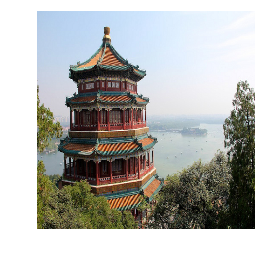

In [33]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

W0323 19:04:32.720291 140735783818112 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


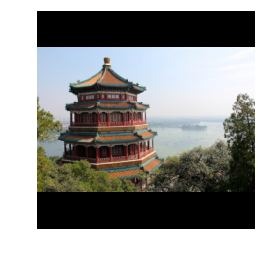

In [34]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

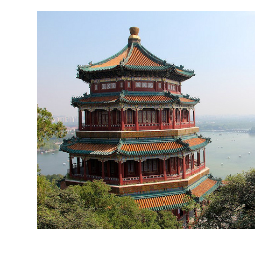

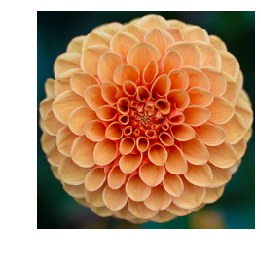

In [36]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

Finally, use `Y_proba = model.predict(inputs)` to **make predictions**(`Y_proba` is a matrix with one row per image and one column per class) and use the `decode_predictions()` function to **display the top K predictions.**

In [37]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [38]:
Y_proba.shape

(2, 1000)

In [39]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       42.87%
  n02825657 - bell_cote    40.57%
  n03781244 - monastery    14.56%

Image #1
  n04522168 - vase         46.83%
  n07930864 - cup          7.78%
  n11939491 - daisy        4.87%



# Pretrained Models for Transfer Learning   
What if you want to **use an image classifier for classes of images that are not part of ImageNet** ? In that case, you may perform transfer learning.   
If you want to build an image classifier, but do **not have enough training data**, then it is often a good idea to **reuse the lower layers of a pretrained model**. Let’s train a model to classify pictures of flowers.

In [40]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [41]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [42]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [43]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [44]:
n_classes = info.features["label"].num_classes

In [45]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [46]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

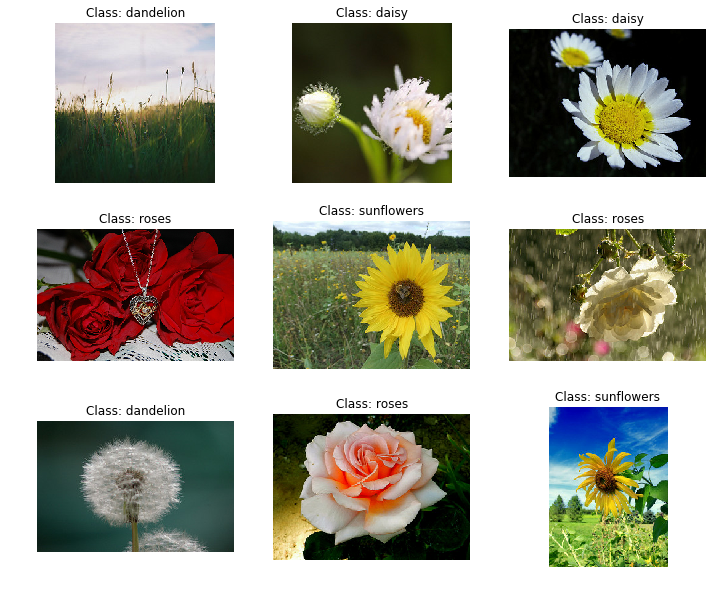

In [47]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

**Basic preprocessing:** resize and scale

In [48]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

**More preprocessing:** perform some data augmentation, shuffle & repeat the training set, add batching & prefetching to all datasets:

In [49]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

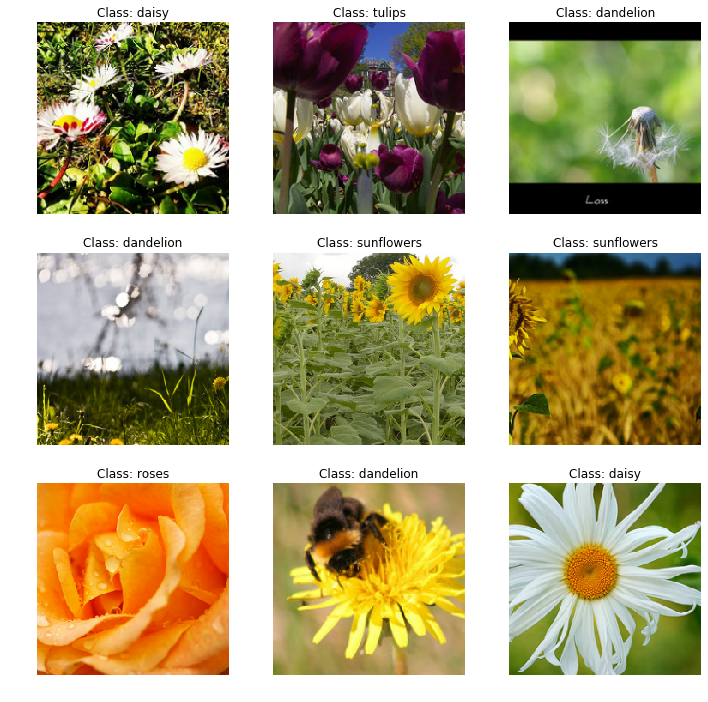

In [50]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [52]:
# Next let’s load an Xception model, pretrained on ImageNet
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [53]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_35
15 add_16
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_36
25 add_17
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_37
<<62 more lines>>
97 block11_sepconv1
98 block11_sepconv1_bn
99 block11_sepconv2_act
100 block11_sepconv2
101 block11_sepconv2_bn
102 block11_sepconv3_act
103 block11_sepconv3
104 block11_sepconv3_bn
105 add_25
106 block12_sepconv1_act
107 block12_sepconv1
108 block12_sepconv1_bn
109 block12_sepconv2_act
110 block12_sepconv2
111 block12_sepconv

In [54]:
# freeze the weights of the pretrained layers at the beginning of training
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 46s 532ms/step - loss: 0.6858 - accuracy: 0.7758 - val_loss: 1.7375 - val_accuracy: 0.7335
Epoch 2/5
86/86 [==============================] - 39s 450ms/step - loss: 0.3833 - accuracy: 0.8765 - val_loss: 1.2491 - val_accuracy: 0.7592
Epoch 3/5
86/86 [==============================] - 39s 450ms/step - loss: 0.3270 - accuracy: 0.8903 - val_loss: 1.2740 - val_accuracy: 0.7647
Epoch 4/5
86/86 [==============================] - 39s 451ms/step - loss: 0.2821 - accuracy: 0.9113 - val_loss: 1.1322 - val_accuracy: 0.7757
Epoch 5/5
86/86 [==============================] - 39s 452ms/step - loss: 0.2430 - accuracy: 0.9121 - val_loss: 1.5182 - val_accuracy: 0.7426


In [55]:
# unfreeze all layers and continue training with a much lower learning rate
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 172s 2s/step - loss: 0.2257 - accuracy: 0.9288 - val_loss: 0.6762 - val_accuracy: 0.8346
Epoch 2/40
86/86 [==============================] - 128s 1s/step - loss: 0.1124 - accuracy: 0.9640 - val_loss: 0.3932 - val_accuracy: 0.9154
Epoch 3/40
86/86 [==============================] - 129s 1s/step - loss: 0.0497 - accuracy: 0.9829 - val_loss: 0.2618 - val_accuracy: 0.9246
Epoch 4/40
86/86 [==============================] - 128s 1s/step - loss: 0.0425 - accuracy: 0.9836 - val_loss: 0.3446 - val_accuracy: 0.9136
Epoch 5/40
86/86 [==============================] - 128s 1s/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.2486 - val_accuracy: 0.9338
Epoch 6/40
86/86 [==============================] - 127s 1s/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.2324 - val_accuracy: 0.9430
Epoch 7/40
86/86 [==============================] - 128s 1s/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.2785 - val_accuracy: 0.9357
Epoch 8/40
86

# Classification and Localization   
What if you also want to know where the flower is in the picture?   
**Idea:** Localizing an object in a picture can be expressed as a regression task: to predict a bounding box around the object - the **horizontal and vertical coordinates** of the object’s center, as well as its **height and width.**   
**Method:** We just need to add a second dense output layer with 4 units.

In [56]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [57]:
# create a dataset whose contains class labels and their bounding boxes
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [58]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 134s 27s/step - loss: 1.3279 - dense_5_loss: 1.5696 - dense_6_loss: 0.3612 - dense_5_accuracy: 0.2625 - dense_6_accuracy: 0.2562
Epoch 2/2
5/5 [==============================] - 93s 19s/step - loss: 1.0533 - dense_5_loss: 1.2658 - dense_6_loss: 0.2035 - dense_5_accuracy: 0.5938 - dense_6_accuracy: 0.2000


**Intersection over Union (IoU)：** most common metric to evaluate how well the model can predict bounding boxes, implemented by the `tf.keras.metrics.MeanIoU` class   
![title](img/14_23.png)   
What if the images contain multiple objects?
# Object Detection:
**Definition:** classify and localize multiple objects in an image   
**Methods:**    
1.Take a CNN that was trained to classify and locate a single object, then slide it across the image. Use **non-max suppression** to get rid of all the unnecessary bounding boxes(repeat identification).   
2.faster way to slide a CNN across an image: using a Fully Convolutional Network   
## Fully Convolutional Networks   
**Goal:** It is used for **semantic segmentation** (the task of classifying every pixel in an image according to the class of the object it belongs to).    
**Composition:** replace the dense layers at the top of a CNN by convolutional layers   
**Features:** much more efficient, since the network only looks at the image once compared to CNN.   
![title](img/14_25.png) 
## YOLO   
**Difference:**    
outputs 5 bounding boxes for each grid cell, and each bounding box comes with an objectness score;   
predicts an offset relative to the coordinates of the grid cell;   
anchors boxes before training the neural net;   
uses images of different scales to train.

# Mean Average Precision (mAP)   
召回率与精确率用于衡量分类器的没有漏报和没有虚警比例，或者说，用来衡量机器做出阴性和阳性判断时的可信度。   
**Tradeoff:** the higher the recall, the lower the precision   
But note that the Precision/Recall curve may contain a few sections where **precision actually goes up when recall increases**, especially at low recall values.   
![title](img/3_5.png)    
There’s really no tradeoff here: it simply makes more sense to use the latter classifier.   
**Procedure:** Compute the maximum precision you can get with at least 0% recall, then 10% recall, 20%, and so on up to 100%, and then calculate the mean of these maximum precisions(the Average Precision (AP) metric).

In [59]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

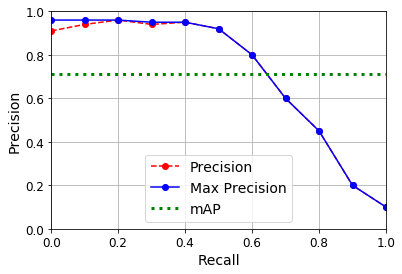

In [60]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

# Semantic Segmentation   
**Definition:** Each pixel is classified according to the class of the object it belongs to. Note that **different objects of the same class are not distinguished.**   
![title](img/14_26.png) 
**Challenge:** When images go through a regular CNN, they gradually lose their spatial resolution (due to the strides).   
**Methods:** Start by taking a pretrained CNN and **turning into an FCN.** When the CNN applies a stride of N to the input image overall, they add a single **upsampling layer** that **multiplies the resolution by N.**   
**Transposed convolutional layer:** it is equivalent to first stretching the image by inserting empty rows and columns (full of zeros), then performing a regular convolution, implemented with `keras.layers.Conv2DTranspose()`.    

In [65]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])


# Instance segmentation
**Definition:** Similar to semantic segmentation, but each object is distinguished from the others.     
**Implement:** TensorFlow provide multiple implementations of the Mask R-CNN architecture.